In [ ]:
import sys
sys.path.append('../')

In [6]:
import config

config.print_config()

import dataloader

train_loader, test_loader = dataloader.get_dataloader(
    config.DATASET, config.BATCH_SIZE, config.NUM_WORKERS)

DATASET: MNIST
BATCH_SIZE: 64
NUM_WORKERS: 4
DEVICE: cpu
LOG_INTERVAL: 100
MODEL_DIR: models
MODEL_NAME: nn_model.pth
DRY_RUN: False
LEARNING_RATE: 0.001
EPOCHS: 1
MOMENTUM: 0.9
N_INPUT: 784
N_CLASSES: 10


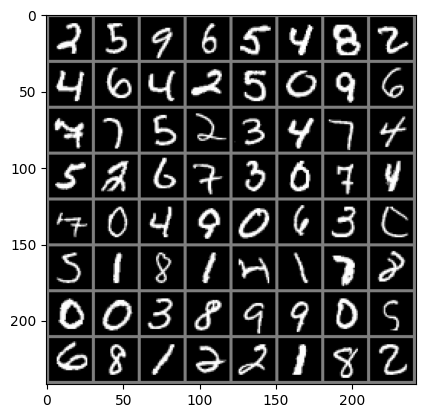

2     5     9     6     5     4     8     2     4     6     4     2     5     0     9     6     7     7     5     2     3     4     7     4     5     2     6     7     3     0     7     4     7     0     4     9     0     6     3     0     5     1     8     1     4     1     7     8     0     0     3     8     9     9     0     5     6     8     1     2     2     1     8     2    


In [7]:
import torchvision

dataiter = iter(train_loader)
images, labels = next(dataiter)

dataloader.imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{dataloader.classes[config.DATASET.lower()][labels[j]]:5s}' for j in range(config.BATCH_SIZE)))

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super(Net, self).__init__()
        self.n_input = n_input
        self.fc1 = nn.Linear(n_input, 128)
        self.fc2 = nn.Linear(128, n_output)

    def forward(self, x):
        x = x.view(-1, self.n_input)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class Net2(nn.Module):
    def __init__(self, n_input, n_output):
        super(Net2, self).__init__()
        self.n_input = n_input
        self.model = nn.Sequential(
            nn.Linear(n_input, 128),
            nn.ReLU(),
            nn.Linear(128, n_output)
        )

    def forward(self, x):
        x = x.view(-1, self.n_input)
        x = self.model(x)
        return x
    
net = Net(config.N_INPUT, config.N_CLASSES)


import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=config.LEARNING_RATE, momentum=config.MOMENTUM)


def train(epoch):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % config.LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if config.DRY_RUN:
                break

def test():
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = net(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
for epoch in range(1, config.EPOCHS + 1):
    train(epoch)
    test()

if not config.DRY_RUN:
    torch.save(net.state_dict(), f"{config.MODEL_DIR}/{config.MODEL_NAME}")
    print(f"Model saved to {config.MODEL_DIR}/{config.MODEL_NAME}")
    




Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308316
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.583109
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.907308
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.757247
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.519437
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.506602
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.570409
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.399082
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.430115
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.479404

Test set: Average loss: 0.0062, Accuracy: 8931/10000 (89%)

Model saved to models/nn_model.pth


In [ ]:
import tensorboard
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()
dataiter = iter(test_loader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# write to tensorboard
writer.add_image('batch_mnist', img_grid)

# write model to tensorboard
writer.add_graph(net, images)
writer.close()

print("Done!")

2024-08-21 00:28:41.380729: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-21 00:28:41.383663: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-21 00:28:41.514636: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-21 00:28:42.039378: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-21 00:28:44.833748: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

Done!
